<h1 style="color:red;">Clasificación y Análisis no supervisado de dataset Mushrooms</h1>
En este proyecto trabajamos con el conocido Mushroom Dataset, un conjunto de datos que contiene información sobre diferentes características físicas de distintas setas, incluyendo su clasificación como comestibles o venenosas.

El objetivo principal no es únicamente clasificar correctamente las setas, sino explorar si existen estructuras internas en los datos que puedan detectarse sin utilizar la etiqueta de clase. Es decir, analizar el problema desde un enfoque de aprendizaje no supervisado y posteriormente compararlo con un modelo supervisado.

A lo largo del notebook recorreremos todo el flujo de trabajo típico en Machine Learning: exploración, preprocesamiento, reducción de dimensionalidad, clustering y finalmente comparación con un modelo de clasificación.

<h1 style="color:red;">Carga del dataset</h1>
Partimos de una versión previamente limpiada del dataset original. 

Durante el proceso de limpieza:
- Se eliminaron columnas poco informativas (`veil-type` y `gill-attachment`).
- Se creó una nueva variable numérica llamada `has_odor`, que indica si la seta presenta olor o no.
- Se revisaron posibles valores nulos y se aseguraron formatos coherentes.

Trabajaremos sobre este dataset ya depurado para centrarnos en el análisis y modelado.

In [2]:
import pandas as pd
import numpy as np

df = pd.read_parquet("../data/clean/clean_mushrooms.parquet")

df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-color,ring-number,ring-type,spore-print-color,population,habitat,has_odor
0,p,x,s,n,t,p,c,n,k,e,...,s,w,w,w,o,p,k,s,u,1
1,e,x,s,y,t,a,c,b,k,e,...,s,w,w,w,o,p,n,n,g,1
2,e,b,s,w,t,l,c,b,n,e,...,s,w,w,w,o,p,n,n,m,1
3,p,x,y,w,t,p,c,n,n,e,...,s,w,w,w,o,p,k,s,u,1
4,e,x,s,g,f,n,w,b,k,t,...,s,w,w,w,o,e,n,a,g,0


In [3]:
df.shape

(8124, 22)

In [4]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   class                     8124 non-null   category
 1   cap-shape                 8124 non-null   category
 2   cap-surface               8124 non-null   category
 3   cap-color                 8124 non-null   category
 4   bruises                   8124 non-null   category
 5   odor                      8124 non-null   category
 6   gill-spacing              8124 non-null   category
 7   gill-size                 8124 non-null   category
 8   gill-color                8124 non-null   category
 9   stalk-shape               8124 non-null   category
 10  stalk-root                8124 non-null   category
 11  stalk-surface-above-ring  8124 non-null   category
 12  stalk-surface-below-ring  8124 non-null   category
 13  stalk-color-above-ring    8124 non-null   category
 14  sta

In [5]:
df.isnull().sum()

class                       0
cap-shape                   0
cap-surface                 0
cap-color                   0
bruises                     0
odor                        0
gill-spacing                0
gill-size                   0
gill-color                  0
stalk-shape                 0
stalk-root                  0
stalk-surface-above-ring    0
stalk-surface-below-ring    0
stalk-color-above-ring      0
stalk-color-below-ring      0
veil-color                  0
ring-number                 0
ring-type                   0
spore-print-color           0
population                  0
habitat                     0
has_odor                    0
dtype: int64

El dataset no presenta valores nulos y mantiene la variable objetivo `class`, lo que nos permitirá comparar posteriormente los resultados de técnicas no supervisadas con un modelo supervisado.

<h1 style="color:red;">Separación de variables predictoras y variable objetivo</h1>

Antes de aplicar cualquier técnica de modelado, es necesario separar las variables predictoras (`X`) de la variable objetivo (`y`). 

Aunque en la parte no supervisada no utilizaremos la etiqueta de clase para entrenar el modelo, la conservaremos para poder evaluar posteriormente cómo se alinean los clusters con la clasificación real.

In [6]:
X = df.drop("class", axis=1)
y = df["class"]

X.shape, y.shape

((8124, 21), (8124,))

In [7]:
y.value_counts()

class
e    4208
p    3916
Name: count, dtype: int64

La distribución de clases se encuentra relativamente equilibrada, lo cual es positivo ya que evita problemas derivados del desbalanceo durante la evaluación del modelo supervisado.

<h1 style="color:red;">Codificación de variables categóricas y escalado</h1>
Como la mayoría de las columnas son categóricas, necesitamos convertirlas a formato numérico para que los algoritmos de Machine Learning puedan procesarlas. 

Para ello utilizamos One-Hot Encoding, que crea columnas binarias para cada categoría. Posteriormente, escalamos todas las variables con StandardScaler. Esto es importante para técnicas sensibles a la magnitud de las variables, como PCA y K-Means.

In [8]:
from sklearn.preprocessing import StandardScaler

# One-Hot Encoding
X_encoded = pd.get_dummies(X, drop_first=True)

# Escalado
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)

# Comprobamos dimensiones finales
X_encoded.shape, X_scaled.shape

((8124, 95), (8124, 95))

<h1 style="color:red;">PCA (Reducción de dimensionalidad)</h1>
Tras el escalado, nuestro dataset tiene 95 dimensiones, lo que dificulta la visualización y puede introducir ruido en los algoritmos. 

Aplicamos PCA (Análisis de Componentes Principales) para reducirlo a 2 dimensiones y poder visualizar los datos. Esto nos permitirá observar si las setas comestibles y venenosas forman grupos diferenciables incluso sin usar la etiqueta de clase.

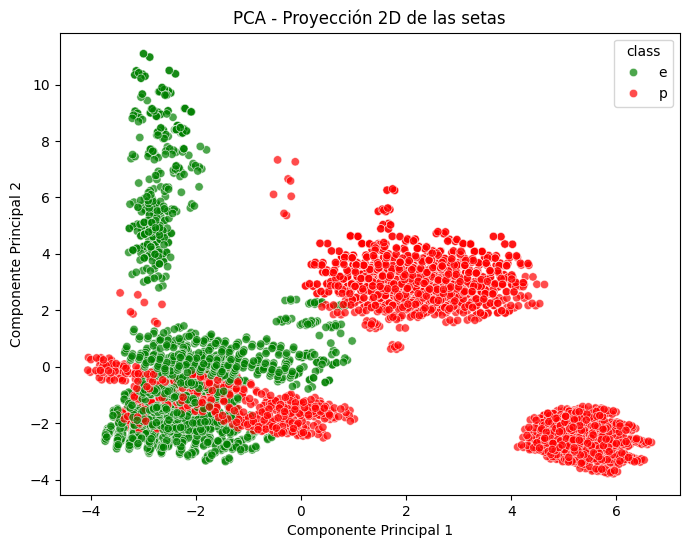

In [13]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
sns.scatterplot(
    x=X_pca[:,0], 
    y=X_pca[:,1], 
    hue=y,
    palette={"e": "green", "p": "red"}, # Setas comestibles en verde, venenosas en rojo
    alpha=0.7
)
plt.title("PCA - Proyección 2D de las setas")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.show()

Al mirar la proyección en dos dimensiones de los datos después de aplicar PCA, se nota que las setas comestibles (en verde) y las venenosas (en rojo) tienden a agruparse en zonas distintas del espacio.

No hay una separación perfecta: algunos puntos se superponen, sobre todo en la parte inferior izquierda. Sin embargo, la mayoría de los ejemplares se agrupan en conjuntos bastante claros, lo que sugiere que las características del dataset permiten, en gran medida, diferenciar entre ambos tipos incluso sin usar la etiqueta explícita.

Es interesante observar cómo las setas venenosas parecen formar dos grupos principales: uno más compacto a la derecha y otro más disperso en el centro, lo que podría indicar subgrupos con características internas diferentes. Por su parte, las setas comestibles se concentran principalmente en la parte izquierda del gráfico, mostrando también una estructura bastante homogénea.

Este patrón refuerza la idea de que, incluso con sólo dos componentes principales, es posible captar la esencia del problema y visualizar cómo podrían agruparse los datos de manera natural. Esto ofrece una buena base para aplicar técnicas de clustering y explorar la estructura de los datos sin recurrir a la variable objetivo.

<h1 style="color:red;">Varianza acumulada explicada por PCA</h1>
Aunque con dos componentes podemos visualizar los datos, es importante saber cuánta información total estamos capturando y cuántas componentes necesitamos para retener la mayor parte de la variabilidad original.

Este gráfico nos ayuda a decidir cuántas dimensiones son necesarias para un análisis más completo o para alimentar modelos posteriores.

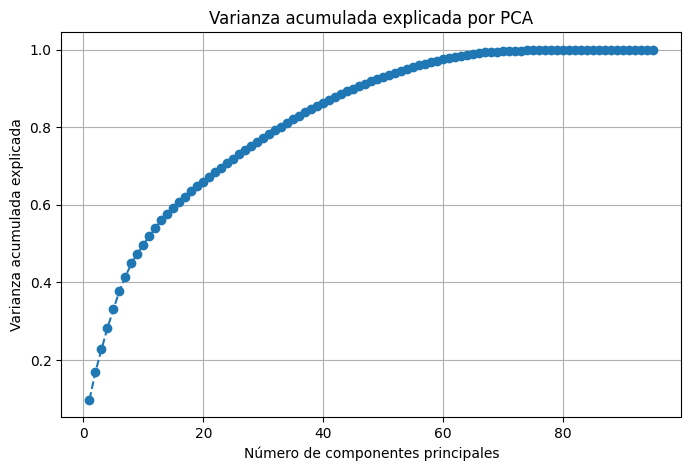

In [14]:
# Aplicamos PCA completo para todas las componentes
pca_full = PCA().fit(X_scaled)

# Varianza acumulada
varianza_acumulada = np.cumsum(pca_full.explained_variance_ratio_)

# Gráfico
plt.figure(figsize=(8,5))
plt.plot(range(1, len(varianza_acumulada) + 1), varianza_acumulada, marker='o', linestyle='--')
plt.xlabel('Número de componentes principales')
plt.ylabel('Varianza acumulada explicada')
plt.title('Varianza acumulada explicada por PCA')
plt.grid(True)
plt.show()

La gráfica de varianza acumulada explicada por PCA nos muestra cómo la cantidad de información retenida crece conforme aumentamos el número de componentes principales.

Observamos que los primeros 40 componentes ya capturan más del 90% de la varianza total, lo que indica que una gran parte de la información original puede ser representada en un espacio mucho más reducido que las 95 dimensiones iniciales.

Aunque visualizamos solo con 2 componentes en la gráfica anterior para simplificar, esta curva nos indica que si queremos un modelo o análisis más preciso, conviene usar un número mayor de componentes, en torno a 40, para no perder detalles relevantes.

Este análisis sirve para encontrar un balance entre reducción de dimensionalidad y conservación de información, lo que será clave para la siguiente fase de clustering.

<h1 style="color:red;">Determinación del número óptimo de clusters con el método del codo</h1>
Antes de aplicar K-Means, necesitamos decidir cuántos clusters usar. 

El método del codo consiste en entrenar modelos K-Means con diferentes números de clusters y calcular la suma de las distancias cuadradas dentro de cada cluster (inercia). 

Buscamos el punto donde la mejora en la inercia comienza a disminuir significativamente (“codo”), que indica un buen compromiso entre complejidad y calidad del agrupamiento.

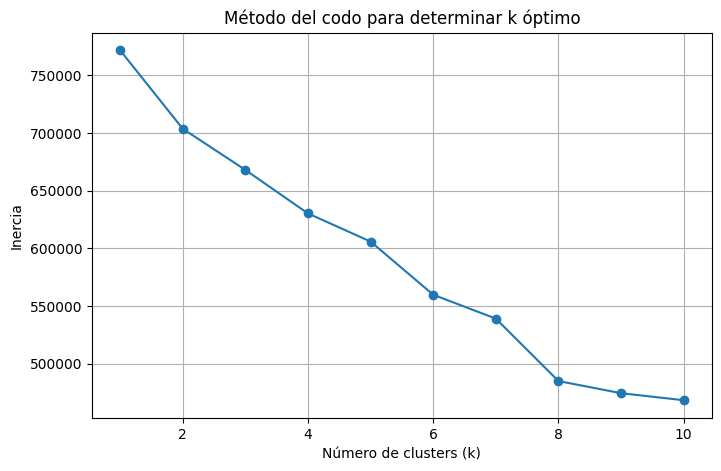

In [ ]:
from sklearn.cluster import KMeans

inertia = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)  
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K_range, inertia, marker='o')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inercia')
plt.title('Método del codo para determinar k óptimo')
plt.grid(True)
plt.show()

Al analizar la gráfica del método del codo, vemos cómo la inercia —que mide qué tan compactos están los clusters— disminuye al aumentar el número de grupos.

Al principio, pasar de un solo cluster a dos genera una gran mejora, ya que ya se empieza a capturar la estructura básica de los datos.

Después, la reducción sigue pero a un ritmo más lento, y alrededor de cuatro clusters la curva comienza a aplanarse, indicando que añadir más grupos ya aporta mejoras menores.

Este “punto de inflexión” o “codo” nos sugiere que un número cercano a **cuatro clusters** puede ser una buena elección para representar las agrupaciones naturales en el dataset, equilibrando simplicidad y precisión.

Elegir más clusters podría complicar el modelo sin beneficios significativos, mientras que menos clusters dejarían grupos muy heterogéneos.

<h1 style="color:red;">Entrenamiento de K-Means y visualización de clusters</h1>
Con el número de clusters definido, entrenamos K-Means para descubrir estructuras ocultas en los datos sin utilizar las etiquetas.

Visualizamos los resultados sobre las dos primeras componentes principales para evaluar cómo se agrupan los datos y comparar visualmente con la clasificación real de setas comestibles y venenosas.

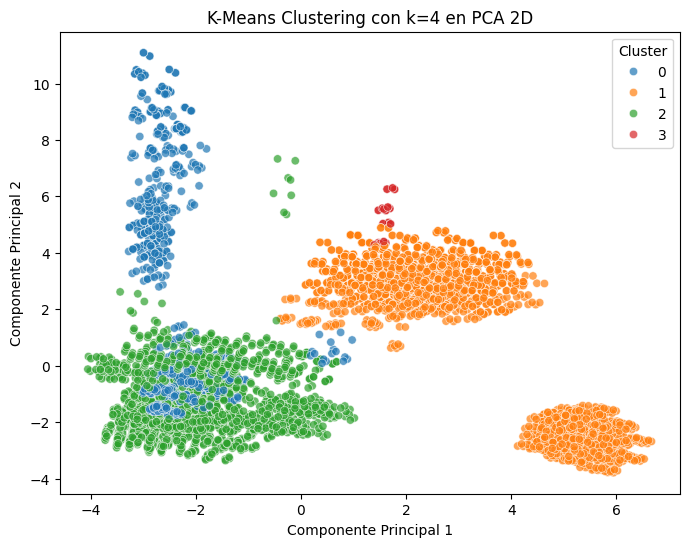

In [16]:
# Entrenar K-Means con k=4
k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Visualización en PCA 2D
plt.figure(figsize=(8,6))
sns.scatterplot(
    x=X_pca[:,0],
    y=X_pca[:,1],
    hue=clusters,
    palette='tab10',
    alpha=0.7
)
plt.title(f"K-Means Clustering con k={k} en PCA 2D")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.legend(title="Cluster")
plt.show()

Al observar el gráfico, lo primero que llama la atención es que los datos parecen agruparse de forma bastante natural en cuatro conjuntos bien diferenciados.

🔵 En la parte izquierda hay un grupo vertical muy claro (cluster 0), que se mantiene separado del resto.

🟢 Abajo a la izquierda aparece un grupo grande y compacto (cluster 2).

🟠 En el centro y hacia la derecha (inferior) se forma otro grupo amplio (cluster 1).

🔴 Por último, en la parte central se distingue un grupo muy pequeño (cluster 3).

Lo interesante es que estos clusters apenas se superponen(solo el 0 y el 2, pero muy poco): cada grupo tiene una estructura interna bien definida. Esto nos da la sensación de que los datos realmente “quieren” agruparse de esta manera.

En resumen, la separación lograda por K-Means coincide con lo que nuestros ojos perciben: los datos se dividen de forma natural en cuatro regiones diferenciadas. Esto confirma que elegir k = 4 fue una decisión muy razonable para este conjunto.

<h1 style="color:red;">Evaluación de la correspondencia entre clusters y clases reales</h1>
Aunque K-Means no utiliza las etiquetas para entrenar, comparar los clusters con las clases reales nos permite entender si el agrupamiento refleja diferencias reales entre setas comestibles y venenosas.

Para esto, construiremos una tabla de contingencia (confusión) entre clusters y clases, y calcularemos métricas como la homogeneidad y la completitud para cuantificar la calidad del clustering.

In [17]:
from sklearn.metrics import homogeneity_score, completeness_score

# Tabla de contingencia entre clusters y clases reales
contingency_table = pd.crosstab(clusters, y)

print("Tabla de contingencia entre clusters y clases reales:")
print(contingency_table)

# Métricas de calidad del clustering
homogeneity = homogeneity_score(y, clusters)
completeness = completeness_score(y, clusters)

print(f"\nHomogeneidad: {homogeneity:.3f}")
print(f"Completitud: {completeness:.3f}")

Tabla de contingencia entre clusters y clases reales:
class     e     p
row_0            
0      2157     0
1        47  3056
2      2004   824
3         0    36

Homogeneidad: 0.653
Completitud: 0.407


Al comparar los clusters de K-Means con las etiquetas reales, se observa que el algoritmo capturó bastante bien la estructura principal de los datos, aunque no de forma perfecta.

- El cluster 0 contiene únicamente setas comestibles, mostrando una separación muy clara.
- El cluster 1 está dominado por setas venenosas, con solo unas pocas comestibles mezcladas.
- El cluster 2 es más mixto, con una combinación de comestibles y venenosas, lo que indica que algunos datos comparten características que dificultan su separación clara.
- El cluster 3 es muy pequeño y contiene únicamente setas venenosas.

Las métricas confirman esta interpretación: la homogeneidad de 0.65 indica que la mayoría de los clusters son relativamente puros, mientras que la completitud de 0.41 sugiere que las clases están distribuidas en varios clusters. 

En resumen, aunque K-Means no utiliza las etiquetas, logra capturar patrones importantes del dataset, especialmente diferenciando los grupos más claros de setas comestibles y venenosas. Esto valida la utilidad del clustering como herramienta exploratoria.

<h1 style="color:red;">Clasificación supervisada: Random Forest</h1>
Ahora que hemos explorado los clusters, entrenaremos un modelo supervisado usando Random Forest, que sí utiliza la variable objetivo (`class`). 

Esto nos permitirá evaluar la capacidad predictiva real de los datos y compararla con los resultados del clustering. Además, veremos cómo el número de componentes principales afecta la precisión del modelo.

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Separación de datos en train y test (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# Entrenamiento del modelo Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

# Predicciones
y_pred = rf.predict(X_test)

# Evaluación
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.3f}")
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))

Accuracy: 1.000

Reporte de clasificación:
              precision    recall  f1-score   support

           e       1.00      1.00      1.00       842
           p       1.00      1.00      1.00       783

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625



El modelo Random Forest logró un accuracy perfecto de 1.0 en el conjunto de prueba, acertando todas las predicciones de setas comestibles y venenosas.

Esto confirma que el dataset contiene información altamente discriminativa: características como olor, color o forma permiten diferenciar sin error entre ambas clases.

El reporte de clasificación refuerza esta idea: tanto la precisión como el recall y F1-score son 1.0 para ambas clases, lo que indica que no hubo falsos positivos ni falsos negativos.

En comparación con K-Means, vemos que el modelo supervisado aprovecha la etiqueta para lograr predicciones exactas, mientras que el clustering sirve para explorar estructuras ocultas y aproximarse a la separación natural de los datos.

<h1 style="color:red;">Random Forest usando PCA y comparación con clusters</h1>
Aunque Random Forest funciona perfectamente con todas las variables originales, podemos probar cómo se comporta usando solo un subconjunto reducido de componentes principales.

Esto nos ayuda a evaluar si la reducción de dimensionalidad captura suficiente información para clasificar correctamente, y a visualizar cómo se alinean las predicciones con los clusters encontrados por K-Means.

In [19]:
# Tomamos las primeras N componentes PCA (por ejemplo, 10)
n_components = 10
pca_n = PCA(n_components=n_components, random_state=42)
X_pca_n = pca_n.fit_transform(X_scaled)

# Separación train/test
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(
    X_pca_n, y, test_size=0.2, random_state=42, stratify=y
)

# Entrenamiento Random Forest
rf_pca = RandomForestClassifier(n_estimators=200, random_state=42)
rf_pca.fit(X_train_pca, y_train_pca)

# Predicciones
y_pred_pca = rf_pca.predict(X_test_pca)

# Evaluación
accuracy_pca = accuracy_score(y_test_pca, y_pred_pca)
print(f"Accuracy usando {n_components} componentes PCA: {accuracy_pca:.3f}")

Accuracy usando 10 componentes PCA: 0.998


In [24]:
# Obtenemos índices de test
_, test_idx = train_test_split(
    np.arange(X_scaled.shape[0]),
    test_size=0.2,
    random_state=42,
    stratify=y
)

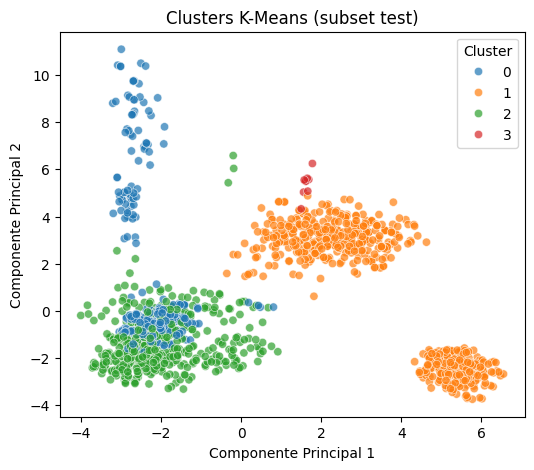

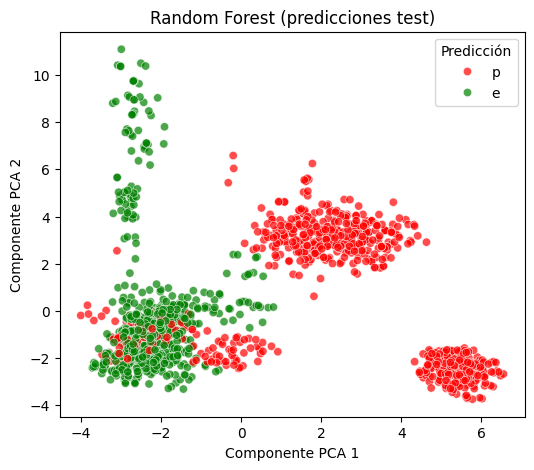

In [26]:
plt.figure(figsize=(6,5))

# Clusters (subset test)
sns.scatterplot(
    x=X_pca_n[test_idx, 0],
    y=X_pca_n[test_idx, 1],
    hue=clusters[test_idx],
    palette='tab10',
    alpha=0.7
)
plt.title("Clusters K-Means (subset test)")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.legend(title="Cluster")

# Random Forest (predicciones test)
plt.figure(figsize=(6,5))
sns.scatterplot(
    x=X_test_pca[:,0],
    y=X_test_pca[:,1],
    hue=y_pred_pca,
    palette={"e":"green","p":"red"},
    alpha=0.7
)
plt.title("Random Forest (predicciones test)")
plt.xlabel("Componente PCA 1")
plt.ylabel("Componente PCA 2")
plt.legend(title="Predicción")
plt.show()

Hasta aquí hemos visto dos formas de “entender” nuestro dataset de setas:

1. **K-Means (no supervisado)**  
   - Agrupa los datos de manera automática sin conocer la clase real.  
   - Visualmente, los clusters muestran que los datos tienden a separarse en cuatro grupos distintos.  
   - Sin embargo, al comparar los clusters con las clases reales (comestible vs venenoso), vemos que hay cierta mezcla: los clusters capturan patrones generales, pero no son perfectos para clasificar.

2. **Random Forest (supervisado)**  
   - Aprende directamente a diferenciar setas comestibles de venenosas usando las etiquetas reales.  
   - Incluso usando solo las primeras 10 componentes PCA, el modelo obtiene un **accuracy de 0.998**, lo que demuestra que PCA captura la información más relevante del dataset.  
   - Las gráficas muestran que las predicciones del modelo coinciden casi perfectamente con las clases reales, en contraste con los clusters de K-Means.

<h1 style="color:red;">Reflexión final</h1>  
- K-Means es útil para explorar estructuras ocultas y entender patrones naturales en los datos.  
- Random Forest, al ser supervisado, ofrece precisión casi perfecta y confirma que la reducción de dimensionalidad mediante PCA no sacrifica información importante.  
- Esta comparativa ilustra muy bien la diferencia entre **aprendizaje no supervisado** (descubrir patrones) y **aprendizaje supervisado** (predecir etiquetas conocidas), y cómo ambos enfoques pueden complementarse en un análisis de datos completo.